## 1. Import Libraries

In [ ]:
# !pip install pillow tensorflow keras matplotlib numpy split-folders
import zipfile
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import shutil
from google.colab import files

## 2. Extract the zip

In [ ]:
with zipfile.ZipFile('/content/Diabetic Retinopathy Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/raw_data')

## 3. Preprocess and crop images

In [ ]:
def process_and_crop_images(input_folder, output_folder, target_size=(150, 150)):
    for category in ['Diabetic Retinopathy', 'No Diabetic Retinopathy']:
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

original_data_path = '/content/raw_data'
cropped_data_path = '/content/Processed_Data'
process_and_crop_images(original_data_path, cropped_data_path)

## 4. Split into train/val/test

In [ ]:
splitfolders.ratio(cropped_data_path, output="/content/Final_Data", seed=42, ratio=(.8, .1, .1))

Copying files: 3662 files [00:00, 6873.32 files/s]


## 5. Create data generators

In [ ]:
train_dir = '/content/Final_Data/train'
val_dir = '/content/Final_Data/val'
test_dir = '/content/Final_Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)


Found 2929 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


## 6. Define CNN model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_retinopathy_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5721 - loss: 0.8269

92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - accuracy: 0.5731 - loss: 0.8249 - val_accuracy: 0.8466 - val_loss: 0.4203
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.8241 - loss: 0.4746 - val_accuracy: 0.8356 - val_loss: 0.4281
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8052 - loss: 0.4752 - val_accuracy: 0.6932 - val_loss: 0.6228
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8534 - loss: 0.4106

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.8534 - loss: 0.4104 - val_accuracy: 0.8904 - val_loss: 0.2732
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.8369 - loss: 0.3903 - val_accuracy: 0.8932 - val_loss: 0.2937
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.8675 - loss: 0.3605 - val_accuracy: 0.8986 - val_loss: 0.3176
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.8742 - loss: 0.3316 - val_accuracy: 0.9205 - val_loss: 0.2990
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8735 - loss: 0.3202 - val_accuracy: 0.8822 - val_loss: 0.3252
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8796 - loss: 0.3137

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.8796 - loss: 0.3138 - val_accuracy: 0.9096 - val_loss: 0.2374
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8756 - loss: 0.3077 - val_accuracy: 0.9123 - val_loss: 0.2766
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.8774 - loss: 0.3146 - val_accuracy: 0.8356 - val_loss: 0.3978
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.8894 - loss: 0.2982 - val_accuracy: 0.8630 - val_loss: 0.3789
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.8805 - loss: 0.3012 - val_accuracy: 0.9014 - val_loss: 0.2807
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.8892 - loss: 0.2913 - val_accuracy: 0.9205 - val_loss: 0.2637


## 8. Evaluate model

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9187 - loss: 0.2351
Test Accuracy: 91.85%


## 10. Classify local image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


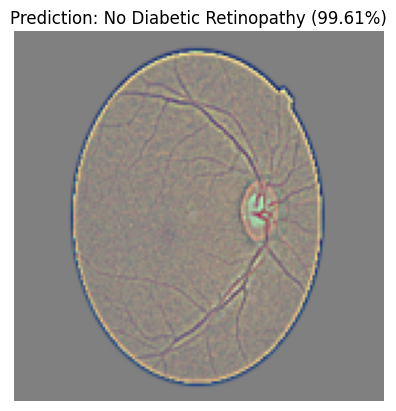

In [ ]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((150, 150))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0][0]
        label = 'No Diabetic Retinopathy' if prediction > 0.5 else 'Diabetic Retinopathy'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

classify_local_image('/content/raw_data/No Diabetic Retinopathy/070d4ce5fd90.png')